In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
from config import api_key

In [2]:
from census import Census
from us import states

In [3]:
# See: https://github.com/CommerceDataService/census-wrapper for library documentation
# See: https://gist.github.com/afhaque/60558290d6efd892351c4b64e5c01e9b for labels

# Census data
* As only civilians are legel to vote, it would make sense to only pull the civilian employment data.
* The labor force is the sum of employed and unemployed persons
* Columns data to pull: 
* Income variables: 
    "income": B19013_001E, "income_per_capita": B19301_001E
* Employment variables:
    "employable civilians": B23025_003E, "employed civilians": B23025_004E, "unemployed civilians": B23025_005E
* Population variables: 
    "Total population": B01003_001E
* Poverty variables:
    "poverty people": "B17001_002E"
    #"poverty_family": "B17012_002E"
    
* Age variables:
    "median age": "B01002_001E" 

# Census 2016

In [4]:
# Census API calls
c = Census(api_key, year=2016)
raw_data = c.acs5.get(('NAME', 'B19013_001E', 'B19301_001E', 'B23025_003E',
                       'B23025_004E', 'B23025_005E', 'B01003_001E', "B01002_001E", "B17001_002E"), {'for':'state:*'})
census_df_raw = pd.DataFrame(raw_data)
census_df_raw = census_df_raw.rename(columns = {'state': 'State#',
                          'NAME': 'State', 
                          'B01003_001E':'Total_population',
                          'B23025_003E':'Employable_civilians',
                          'B23025_004E':'Employed_civilians', 
                          'B23025_005E':'Unemployed_civilians', 
                          'B19013_001E':'Income_median',
                          'B19301_001E':'Income_per_capita',
                          "B01002_001E":'median age',
                          "B17001_002E":'Poverty_count'    
})
census_df_raw = census_df_raw.sort_values('State#').reset_index(drop=True)
# census_df_raw = census_df_raw[['State', 'Total_population','Income_per_capita', 'Employable_civilians', 'Unemployed_civilians','Poverty_count'  ]]
# census_df_raw.head(50)

In [5]:
# Making a summary table 
census_df = census_df_raw.loc[:,['State', 'Total_population', 'Income_median', 'Income_per_capita']]
census_df['Poverty_rate'] = census_df_raw.Poverty_count/census_df_raw.Total_population
census_df['Unemployment_rate'] = census_df_raw.Unemployed_civilians/census_df_raw.Employable_civilians
state_df = pd.read_csv('Resources/state_centroids.csv')
census_df = pd.merge(census_df, state_df, on = 'State')
census_df = census_df.set_index('State')
census_df.head()

,Total_population,Income_median,Income_per_capita,Poverty_rate,Unemployment_rate,Latitude,Longitude
State,,,,,,,
Alabama,4841164.0,44758.0,24736.0,0.179433,0.082856,32.7794,-86.8287
Alaska,736855.0,74444.0,34191.0,0.098834,0.078468,64.0685,-152.2782
Arizona,6728577.0,51340.0,26686.0,0.173237,0.079880,34.2744,-111.6602
Arkansas,2968472.0,42336.0,23401.0,0.182731,0.068535,34.8938,-92.4426
California,38654206.0,63783.0,31458.0,0.155333,0.087417,37.1841,-119.4696


# Vote 2016

In [6]:
csvfile = 'Resources/1976-2016-president.tab'
vote_df = pd.read_csv(csvfile, sep='\t', header=(0))
# vote_df.head()

In [7]:
vote_df_2016_demo_raw = vote_df.loc[(vote_df.year == 2016)&(vote_df.party == 'democrat'), ['state', 'candidatevotes']]
vote_df_2016_demo = vote_df_2016_demo_raw.groupby('state')['candidatevotes'].sum()
vote_df_2016_rep_raw = vote_df.loc[(vote_df.year == 2016)&(vote_df.party == 'republican'),['state', 'candidatevotes']]
vote_df_2016_rep = vote_df_2016_rep_raw.groupby('state')['candidatevotes'].sum()
vote_df_2016_total = vote_df.loc[(vote_df.year == 2016), ['state', 'totalvotes']].groupby('state').mean()['totalvotes']

In [8]:
vote_df_2016 = pd.concat([vote_df_2016_demo, vote_df_2016_rep, vote_df_2016_total],axis=1)
vote_df_2016.columns = ['2016_democrat_votes','2016_republican_votes', '2016_total_votes']
vote_df_2016.head(3)

,2016_democrat_votes,2016_republican_votes,2016_total_votes
state,,,
Alabama,729547,1318255,2123372
Alaska,116454,163387,318608
Arizona,1161209,1252401,2573165


# Dataframe 2016

In [10]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
winner_classifier = LabelEncoder()

df_2016 = census_df.merge(vote_df_2016, left_index=True, right_index=True)
df_2016['votes: demo-rep'] = df_2016['2016_democrat_votes']-df_2016['2016_republican_votes']
# df_2016['winner'] = df_2016['votes: demo-rep']<0
df_2016.loc[df_2016['votes: demo-rep']<0 , 'winner'] = 'Republican'
df_2016.loc[df_2016['votes: demo-rep']>0 , 'winner'] = 'Democrat'
# df_2016['republicans_won'] = winner_classifier.fit_transform(df_2016['winner'])

df_2016.head()

,Total_population,Income_median,Income_per_capita,Poverty_rate,Unemployment_rate,Latitude,Longitude,2016_democrat_votes,2016_republican_votes,2016_total_votes
Alabama,4841164.0,44758.0,24736.0,0.179433,0.082856,32.7794,-86.8287,729547,1318255,2123372
Alaska,736855.0,74444.0,34191.0,0.098834,0.078468,64.0685,-152.2782,116454,163387,318608
Arizona,6728577.0,51340.0,26686.0,0.173237,0.079880,34.2744,-111.6602,1161209,1252401,2573165
Arkansas,2968472.0,42336.0,23401.0,0.182731,0.068535,34.8938,-92.4426,380494,684872,1130635
California,38654206.0,63783.0,31458.0,0.155333,0.087417,37.1841,-119.4696,8753788,4483810,14181595


# 2016 data visualization

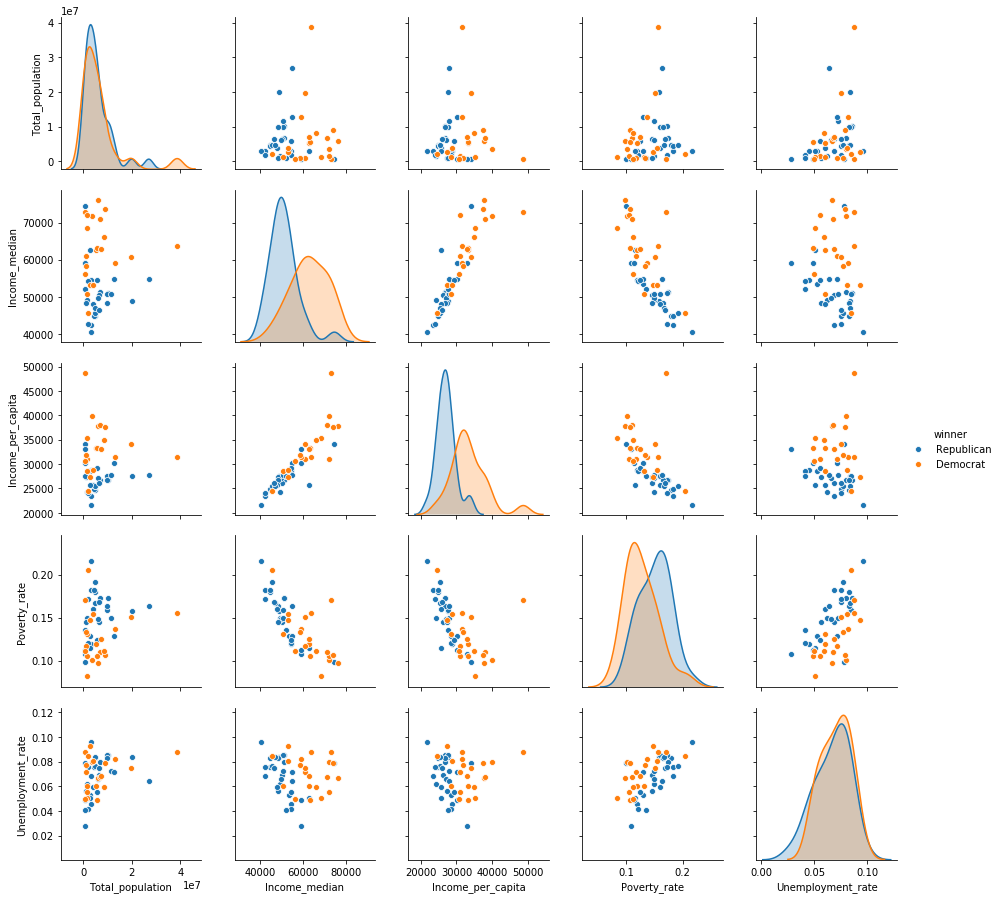

In [22]:
sns.pairplot(df_2016, hue='winner', vars=['Total_population', 'Income_median', 'Income_per_capita', 'Poverty_rate','Unemployment_rate' ] )

# Census 2012

In [11]:
# Census API calls
c = Census(api_key, year=2012)
raw_data = c.acs5.get(('NAME', 'B19013_001E', 'B19301_001E', 'B23025_003E',
                       'B23025_004E', 'B23025_005E', 'B01003_001E', "B01002_001E", "B17001_002E"), {'for':'state:*'})
census_df_raw = pd.DataFrame(raw_data)
census_df_raw = census_df_raw.rename(columns = {'state': 'State#',
                          'NAME': 'State', 
                          'B01003_001E':'Total_population',
                          'B23025_003E':'Employable_civilians',
                          'B23025_004E':'Employed_civilians', 
                          'B23025_005E':'Unemployed_civilians', 
                          'B19013_001E':'Income_median',
                          'B19301_001E':'Income_per_capita',
                          "B01002_001E":'median age',
                          "B17001_002E":'Poverty_count'    
})
census_df_raw = census_df_raw.sort_values('State#').reset_index(drop=True)
# census_df_raw = census_df_raw[['State', 'Total_population','Income_per_capita', 'Employable_civilians', 'Unemployed_civilians','Poverty_count'  ]]
# census_df_raw.head(50)
# Making a summary table 
census_df = census_df_raw.loc[:,['State', 'Total_population', 'Income_median', 'Income_per_capita']]
census_df['Poverty_rate'] = census_df_raw.Poverty_count/census_df_raw.Total_population
census_df['Unemployment_rate'] = census_df_raw.Unemployed_civilians/census_df_raw.Employable_civilians
state_df = pd.read_csv('Resources/state_centroids.csv')
census_df = pd.merge(census_df, state_df, on = 'State')
census_df = census_df.set_index('State')
census_df.head()

,Total_population,Income_median,Income_per_capita,Poverty_rate,Unemployment_rate,Latitude,Longitude
State,,,,,,,
Alabama,4777326.0,43160.0,23587.0,0.176310,0.102629,32.7794,-86.8287
Alaska,711139.0,69917.0,32537.0,0.093696,0.084216,64.0685,-152.2782
Arizona,6410979.0,50256.0,25571.0,0.167679,0.097744,34.2744,-111.6602
Arkansas,2916372.0,40531.0,22007.0,0.181839,0.085633,34.8938,-92.4426
California,37325068.0,61400.0,29551.0,0.149768,0.110285,37.1841,-119.4696


# Vote 2012

In [12]:
csvfile = 'Resources/1976-2016-president.tab'
vote_df = pd.read_csv(csvfile, sep='\t', header=(0))
vote_df.head()
vote_df_2012_demo_raw = vote_df.loc[(vote_df.year == 2012)&(vote_df.party == 'democrat'), ['state', 'candidatevotes']]
vote_df_2012_demo = vote_df_2012_demo_raw.groupby('state')['candidatevotes'].sum()
vote_df_2012_rep_raw = vote_df.loc[(vote_df.year == 2012)&(vote_df.party == 'republican'),['state', 'candidatevotes']]
vote_df_2012_rep = vote_df_2012_rep_raw.groupby('state')['candidatevotes'].sum()
vote_df_2012_total = vote_df.loc[(vote_df.year == 2012), ['state', 'totalvotes']].groupby('state').mean()['totalvotes']
vote_df_2012 = pd.concat([vote_df_2012_demo, vote_df_2012_rep, vote_df_2012_total],axis=1)
vote_df_2012.columns = ['2012_democrat_votes','2012_republican_votes', '2012_total_votes']
vote_df_2012.head(3)

C:\Users\zhan3\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


,2012_democrat_votes,2012_republican_votes,2012_total_votes
Alabama,795696.0,1255925,2074338
Alaska,122640.0,164676,300495
Arizona,1025232.0,1233654,2299254


# Dataframe 2012

In [13]:
df_2012 = census_df.merge(vote_df_2012, left_index=True, right_index=True)
df_2012.head()

,Total_population,Income_median,Income_per_capita,Poverty_rate,Unemployment_rate,Latitude,Longitude,2012_democrat_votes,2012_republican_votes,2012_total_votes
Alabama,4777326.0,43160.0,23587.0,0.176310,0.102629,32.7794,-86.8287,795696.0,1255925,2074338
Alaska,711139.0,69917.0,32537.0,0.093696,0.084216,64.0685,-152.2782,122640.0,164676,300495
Arizona,6410979.0,50256.0,25571.0,0.167679,0.097744,34.2744,-111.6602,1025232.0,1233654,2299254
Arkansas,2916372.0,40531.0,22007.0,0.181839,0.085633,34.8938,-92.4426,394409.0,647744,1069468
California,37325068.0,61400.0,29551.0,0.149768,0.110285,37.1841,-119.4696,7854285.0,4839958,13038547


# Combining data

In [ ]:
df_all_years = pd.concat([df_2016, df_2012], axis=0)

In [ ]:


df_2016['votes: demo-rep'] = df_2016['2016_democrat_votes']-df_2016['2016_republican_votes']
# df_2016['winner'] = df_2016['votes: demo-rep']<0
df_2016.loc[df_2016['votes: demo-rep']<0 , 'winner'] = 'Republican'
df_2016.loc[df_2016['votes: demo-rep']>0 , 'winner'] = 'Democrat'
# df_2016['republicans_won'] = winner_classifier.fit_transform(df_2016['winner'])

# Data analysis and visualization

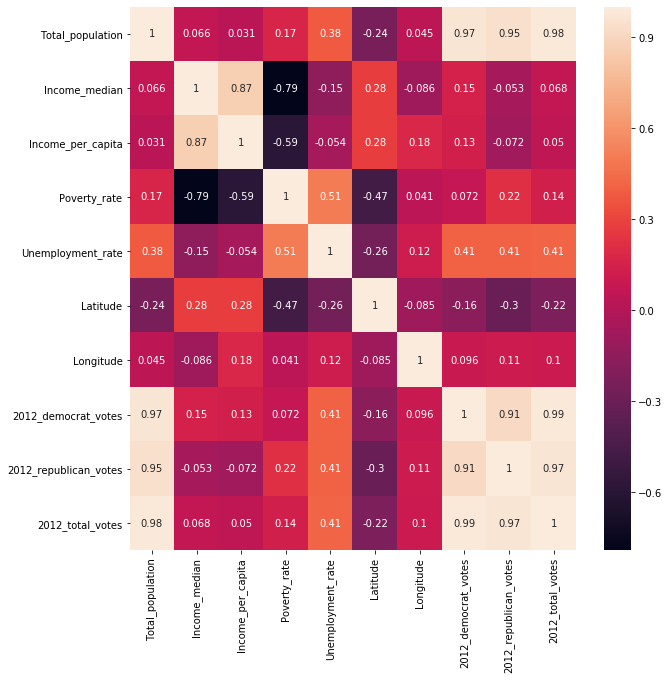

In [24]:
plt.figure(figsize=(10,10))
sns.heatmap(df_2012.corr(),annot=True)

C:\Users\zhan3\Anaconda3\envs\PythonData\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\zhan3\Anaconda3\envs\PythonData\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


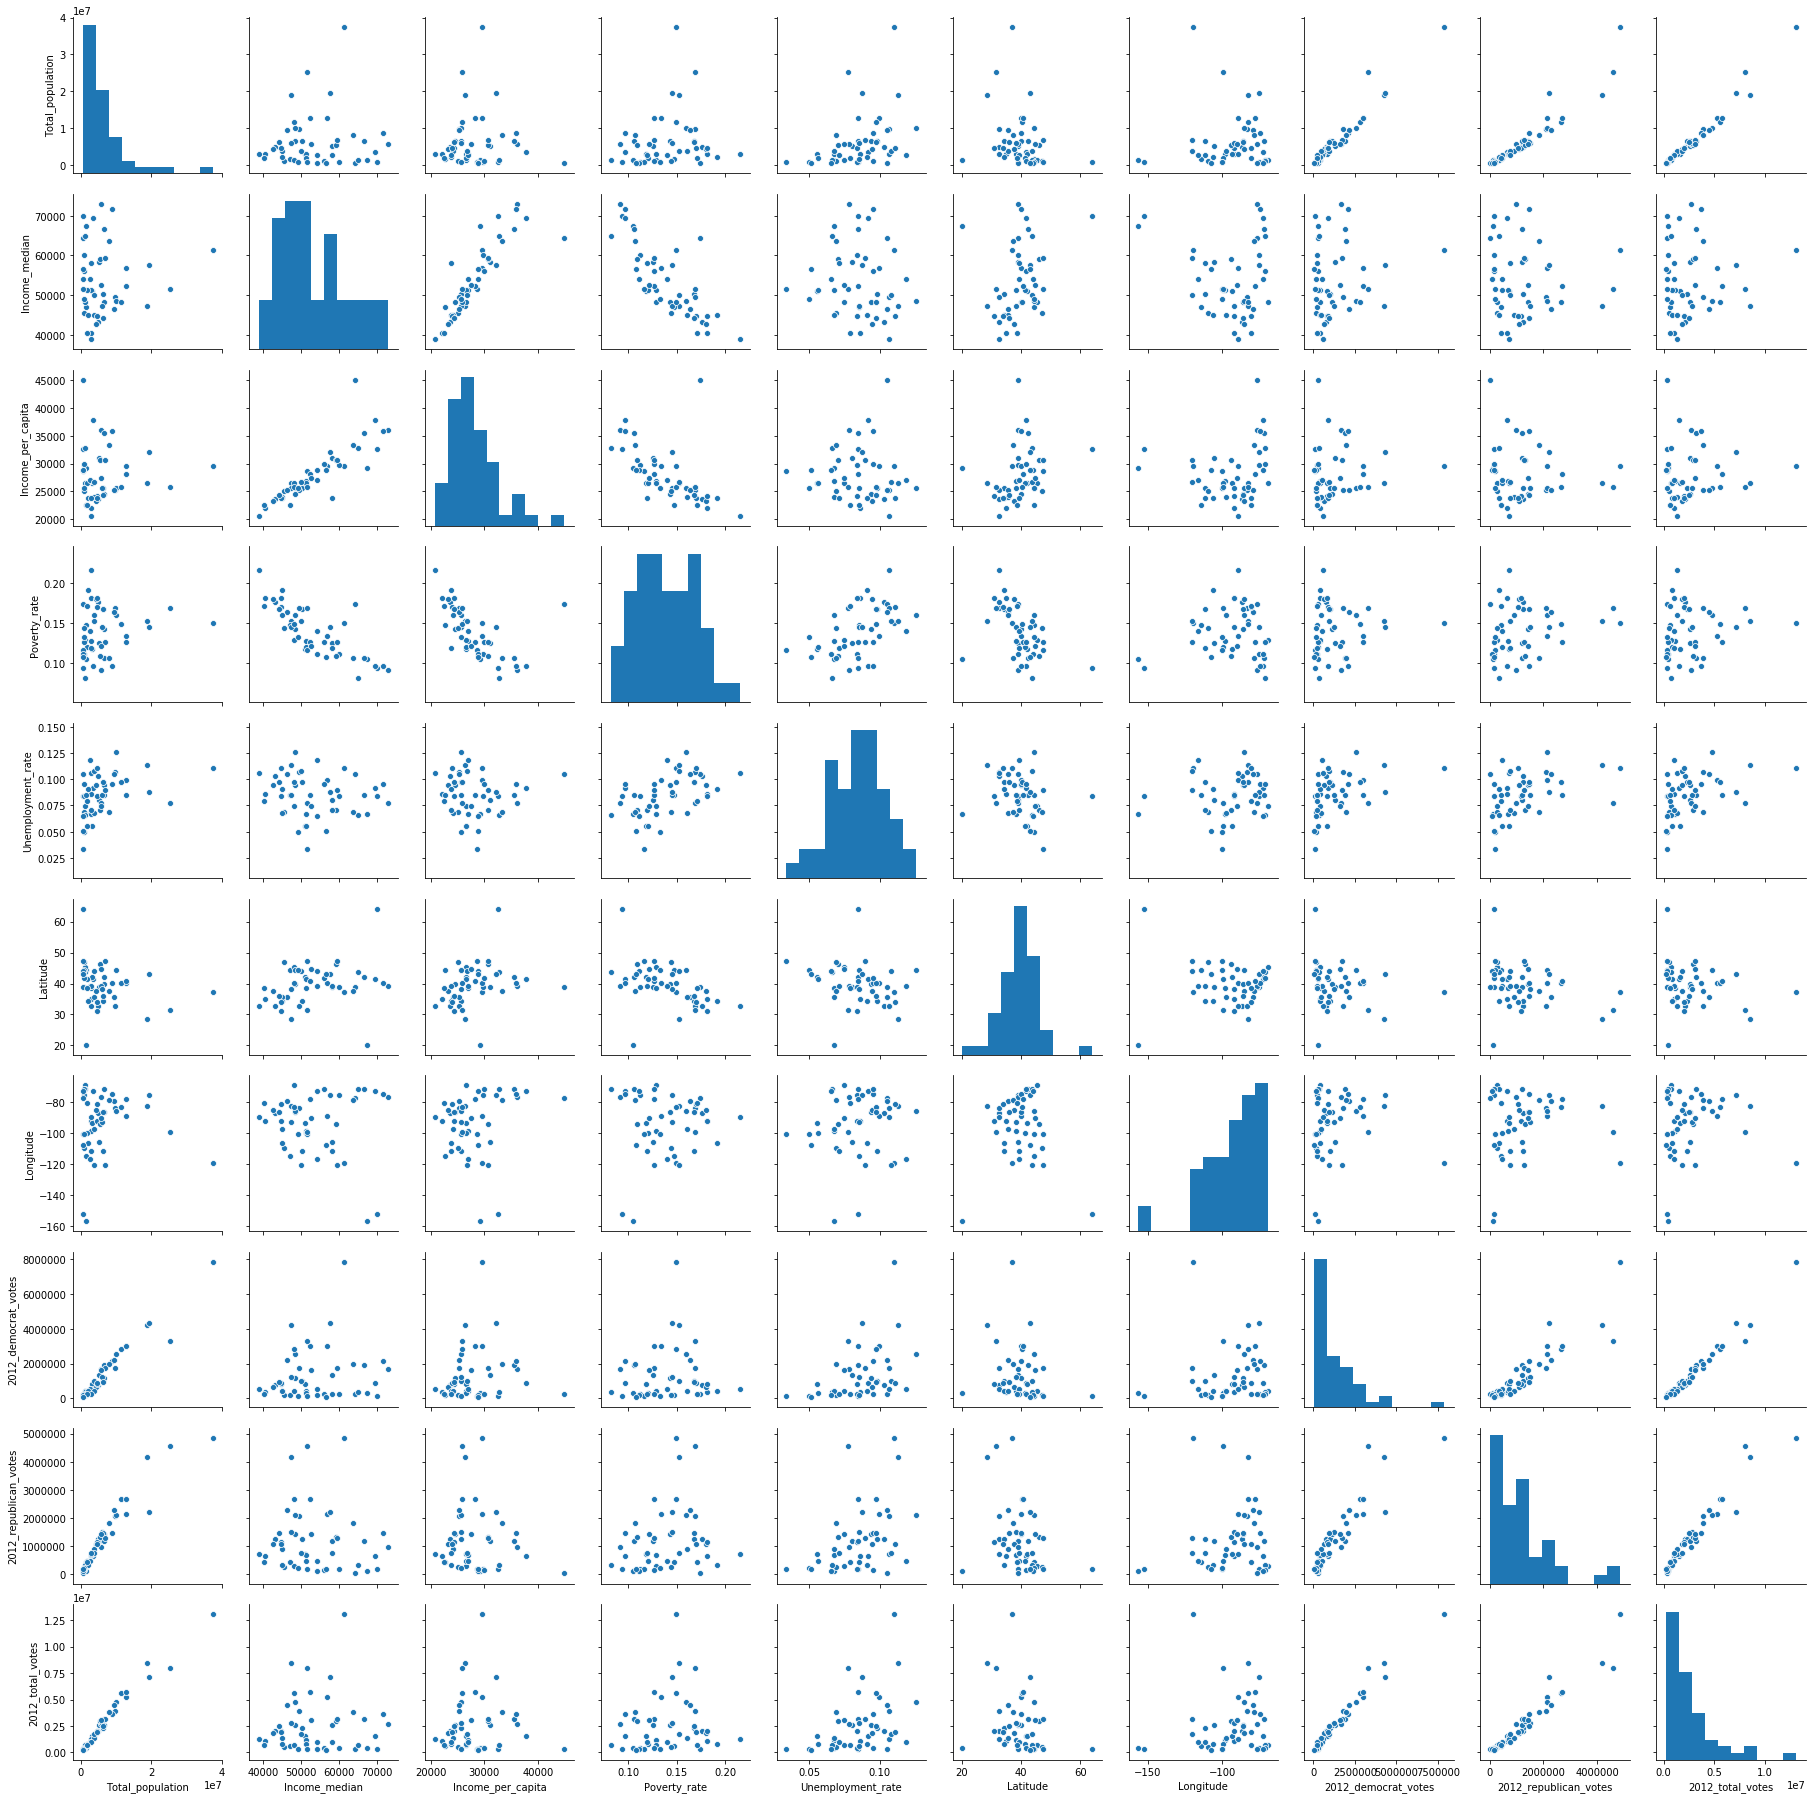

In [25]:
sns.pairplot(df_2012)

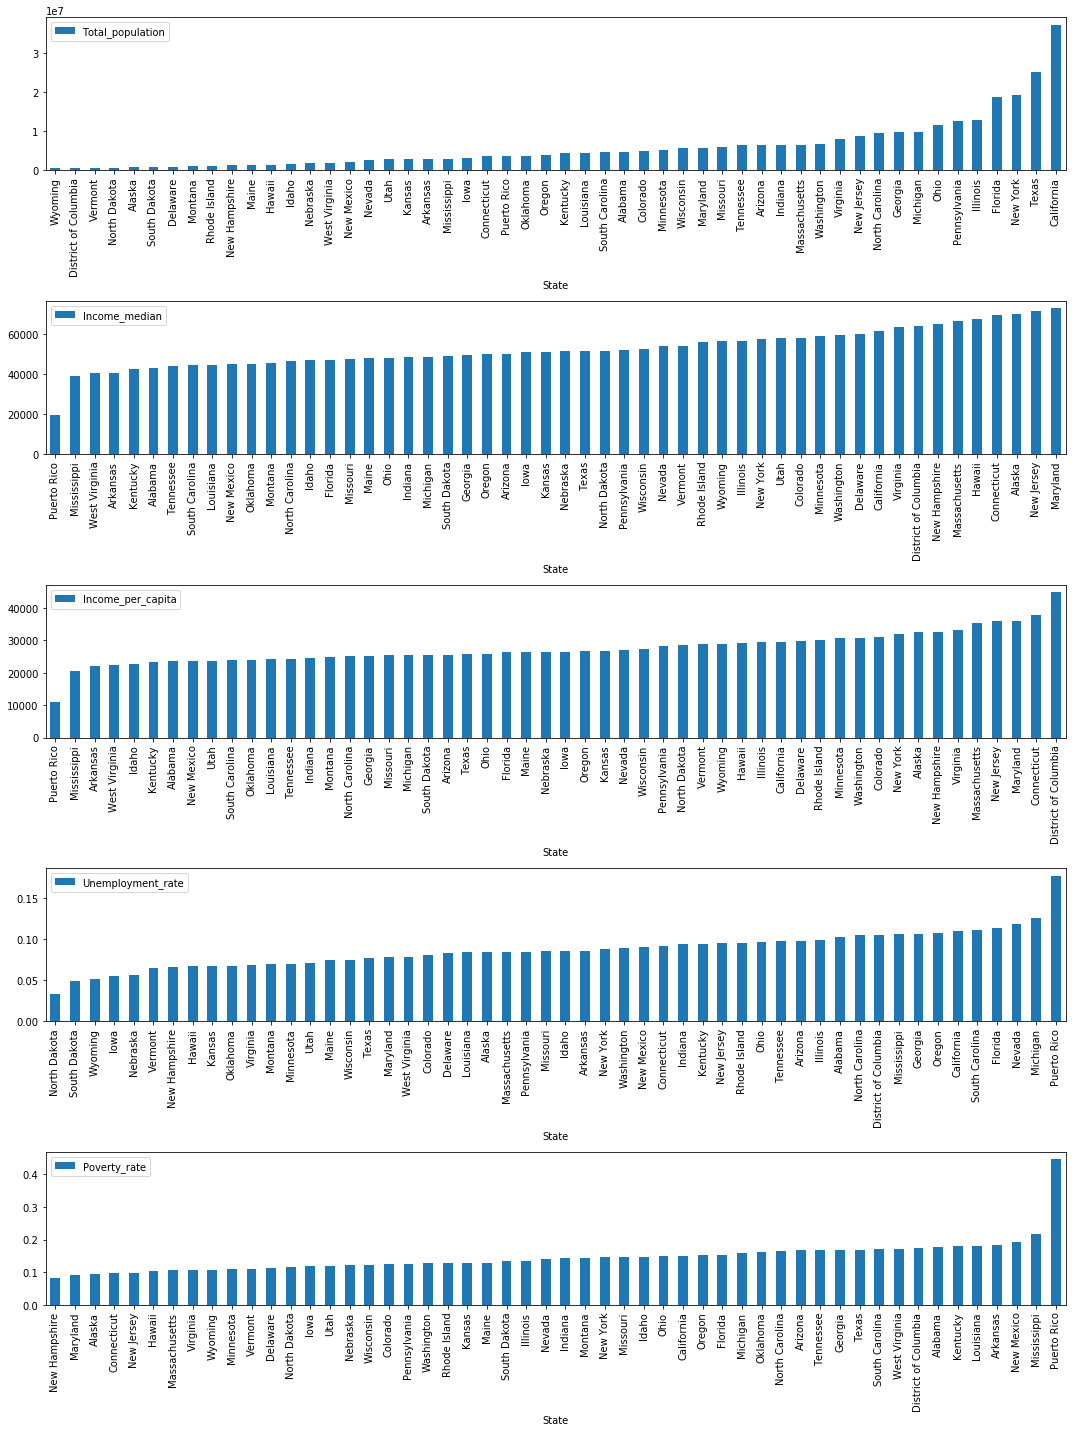

In [13]:
# Visualization via bar plots: population, median income, per capita income, poverty rate, unemployment rate

plt.subplot(511)
fig_population = census_df['Total_population'].sort_values().plot(kind='bar',figsize=(15,20), legend=True)

plt.subplot(512)
fig_income = census_df['Income_median'].sort_values().plot(kind='bar', figsize=(15,20), legend=True)

plt.subplot(513)
fig_capita_income = census_df['Income_per_capita'].sort_values().plot(kind='bar',figsize=(15,20), legend=True)

plt.subplot(514)
fig_unemploy_rate = census_df['Unemployment_rate'].sort_values().plot(kind='bar',figsize=(15,20), legend=True)

plt.subplot(515)
fig_unemploy_rate = census_df['Poverty_rate'].sort_values().plot(kind='bar',figsize=(15,20), legend=True)

plt.tight_layout()

In [14]:
import gmaps
from config import gkey
gmaps.configure(api_key=gkey)

In [15]:
# Settings for gmap figure
figure_layout = {
    'width': '400px',
    'height': '300px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto',
}

# locations of all states
state_coords = census_df.loc[:, ['Latitude', 'Longitude']]

In [16]:
# Population heatmap
# markers = gmaps.marker_layer(state_coords)
# gmap_fig.add_layer(markers)

gmap_fig = gmaps.figure(figure_layout,map_type='HYBRID')
population_layer = gmaps.heatmap_layer(state_coords, weights = census_df['Total_population'],max_intensity = census_df['Total_population'].max(),
                                  dissipating=False, point_radius=3, opacity=0.5)
gmap_fig.add_layer(population_layer)
gmap_fig

Figure(layout=FigureLayout(height='420px'))

In [17]:
# median income heatmap
gmap_fig = gmaps.figure(figure_layout,map_type='HYBRID')
income_layer = gmaps.heatmap_layer(state_coords, weights = census_df['Income_median'],max_intensity = census_df['Income_median'].max(),
                                  dissipating=False, point_radius=3, opacity=0.3)

gmap_fig.add_layer(income_layer)
gmap_fig

Figure(layout=FigureLayout(height='420px'))

In [18]:
# per_capita_income heatmap
gmap_fig = gmaps.figure(figure_layout,map_type='HYBRID')
per_capita_income_layer = gmaps.heatmap_layer(state_coords, weights = census_df['Income_per_capita'],max_intensity = census_df['Income_per_capita'].max(),
                                  dissipating=False, point_radius=3, opacity=0.3)
gmap_fig.add_layer(per_capita_income_layer)
gmap_fig

Figure(layout=FigureLayout(height='420px'))

In [19]:
# Unemployment_rate heatmap
gmap_fig = gmaps.figure(figure_layout,map_type='HYBRID')
unemploy_layer = gmaps.heatmap_layer(state_coords, weights = census_df['Unemployment_rate'], max_intensity = census_df['Unemployment_rate'].max(),
                                  dissipating=False, point_radius=4, opacity=0.6)

gmap_fig.add_layer(unemploy_layer)
gmap_fig

Figure(layout=FigureLayout(height='420px'))

In [20]:
# poverty rate heatmap
gmap_fig = gmaps.figure(figure_layout,map_type='HYBRID')
poverty_layer = gmaps.heatmap_layer(state_coords, weights = census_df['Poverty_rate'],max_intensity = census_df['Poverty_rate'].max(),
                                  dissipating=False, point_radius=4, opacity=0.6)

gmap_fig.add_layer(poverty_layer)
gmap_fig

Figure(layout=FigureLayout(height='420px'))